In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import warnings
import matplotlib.pyplot as plt
import natsort.natsort as ns
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from cellpose import models
from pystackreg import StackReg
from skimage.measure import regionprops_table
from tqdm.auto import tqdm
from glob import glob

In [3]:
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)/"
os.makedirs(fig_dir, exist_ok=True)

In [4]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

colors = [(0, 0, 0), (1, 0, 0)]  # cmap goes from black (0, 0, 0) to red (1, 0, 0)
fluo_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=256)

colors = [(0, 0, 0), (0, 1, 0)]  # cmap goes from black (0, 0, 0) to red (1, 0, 0)
fluo_ref_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=256)

In [5]:
label_cmap = ListedColormap(np.random.rand(50, 3))
label_cmap.set_bad([0, 0, 0])

In [6]:
# first we need to load the data and stitch it all together

In [7]:
# session 2
# point root_dir to the unzipped directory of 2p data
root_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_twophoton_results/"
expt_configs2 = {
    "jrgeco1a-ca2+": {
        "root_dir": root_dir,
        "dirname": "20250521_jRGECO1a_ca2+_sac",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
    "jrgeco1a-egta": {
        "root_dir": root_dir,
        "dirname": "20250522_JRGECO1a_egta",
        "file_glob": "2025-05-21_T-series_BLU6_O02-*",
        "type": "bleaching",
    },
    "jrcamp1b-egta": {
        "root_dir": root_dir,
        "dirname": "20250521_jRCaMP1b_egta",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
    "jrcamp1b-ca2+": {
        "root_dir": root_dir,
        "dirname": "20250521_jRCaMP1b_ca2+_sac",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
    "scarcamp-egta1": {
        "root_dir": root_dir,
        "dirname": "20250521_ScaRCaMP_egta",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
    "scarcamp-egta2": {
        "root_dir": root_dir,
        "dirname": "20250521_ScaRCaMP_egta_2",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
    "scarcamp-ca2+": {
        "root_dir": root_dir,
        "dirname": "20250521_ScaRCaMP_ca2+_sac",
        "file_glob": "2025-05-21_T-series_-*",
        "type": "bleaching",
    },
}
regex = re.compile(r".*\-([0-9]+)")  # get the directory number

In [8]:
expt_configs = expt_configs2

In [9]:
use_channel = 0
register_stack = True

In [10]:
dirs = {}
dirnums = {}
for _exp_name, _cfg in expt_configs.items():
    dirs[_exp_name] = {}
    dirs[_exp_name]["dirnames"] = ns.natsorted(
        glob(os.path.join(root_dir, _cfg["dirname"], _cfg["file_glob"]), recursive=False)
    )
    dirs[_exp_name]["dirnums"] = [int(regex.match(_dir).groups()[0]) for _dir in dirs[_exp_name]["dirnames"]]

    try:
        for _dirs in _cfg["phases"].values():
            inc_dirs += _dirs
        inc_dirs = [i for i, _fnum in enumerate(dirs[_exp_name]["dirnums"]) if _fnum in inc_dirs]
        dirs[_exp_name]["dirnames"] = [_dir for i, _dir in enumerate(dirs[_exp_name]["dirnames"]) if i in inc_dirs]
        dirs[_exp_name]["dirnums"] = [_num for i, _num in enumerate(dirs[_exp_name]["dirnums"]) if i in inc_dirs]
    except KeyError:
        pass

In [11]:
# get all slices in z-stack...pick max fluo?

In [12]:
import xml.etree.ElementTree as ET
import tifffile as tiff
import logging

# disable logging for tifffile just in this loop...
tiff_logger = logging.getLogger("tifffile")
tiff_level = tiff_logger.getEffectiveLevel()  # what's the current level...

In [13]:
from datetime import datetime, timedelta

In [14]:
force = False

In [15]:
tiff_logger.setLevel(logging.CRITICAL + 1)  # set to crit
data = {}
time_series_tstamps = {}
use_first_slice = False
for _exp_name, _path_cfg in tqdm(dirs.items()):

    # session_name go up one directory
    session_name = _path_cfg["dirnames"][0].split(os.sep)[-2]

    # save everything one directory up
    save_dir = f"{os.sep}".join(_path_cfg["dirnames"][0].split(os.sep)[:-2])
    save_fname = os.path.join(save_dir, f"{_exp_name}.pkl")
    if os.path.exists(save_fname) and (not force):
        print("Found data, loading...")
        data[_exp_name] = joblib.load(save_fname)
        continue

    data[_exp_name] = {"arr": [], "tstamp": [], "frame_num": []}
    max_z_slice = None
    for _dir, _num in zip(_path_cfg["dirnames"], _path_cfg["dirnums"]):
        im_files = ns.natsorted(glob(os.path.join(_dir, "*.tif")))
        xml_files = ns.natsorted(glob(os.path.join(_dir, "*.xml")))

        tree = ET.parse(xml_files[0])
        root = tree.getroot()
        frames_metadata = root.findall(".//Sequence/Frame")
        frame_times_secs = [float(_mdata.attrib.get("relativeTime")) for _mdata in frames_metadata]
        scan_time = datetime.strptime(root.attrib.get("date"), "%m/%d/%Y %I:%M:%S %p")

        # highest fluo_slice for ZSeries
        zstack = False
        if "ZSeries" in expt_configs[_exp_name]["file_glob"]:
            zstack = True

        if zstack:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # Ignore all warnings
                im_data = tiff.imread(im_files[0])[use_channel]
            if use_first_slice and (max_z_slice is None):
                max_z_slice = np.mean(im_data, axis=(1, 2)).argmax()
            elif not use_first_slice:
                max_z_slice = np.mean(im_data, axis=(1, 2)).argmax()
            data[_exp_name]["arr"].append(im_data[max_z_slice])
            data[_exp_name]["tstamp"].append(scan_time)
            data[_exp_name]["frame_num"].append(_num)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # Ignore all warnings
                raw_dat = tiff.imread(im_files[0])
                try:
                    im_data = raw_dat[:, use_channel, :, :]
                except IndexError:
                    # no channel dim present!
                    im_data = raw_dat

            data[_exp_name]["arr"].append(im_data)
            data[_exp_name]["tstamp"] += [scan_time + timedelta(seconds=_sec) for _sec in frame_times_secs]

        # max_z_slice = 17
    if zstack:
        data[_exp_name]["arr"] = np.stack(data[_exp_name]["arr"])
    else:
        data[_exp_name]["arr"] = np.concatenate(data[_exp_name]["arr"], axis=0)
        data[_exp_name]["frame_num"] = list(range(len(data[_exp_name]["arr"])))

    # after we're done processing save it all out to a compressed pickle so we can re-use later...

    if register_stack:
        print("Registering stack...")
        tf = StackReg.RIGID_BODY
        sr = StackReg(tf)

        # normalize each frame
        use_data = data[_exp_name]["arr"]
        mu = use_data.mean(axis=(1,2), keepdims=True)
        std = use_data.std(axis=(1,2), keepdims=True)
        norm_data = (use_data - mu) / std
        
        tmats = sr.register_stack(
            data[_exp_name]["arr"],
            axis=0,
            reference="first",
            verbose=False,
        )
        reg_data = sr.transform_stack(data[_exp_name]["arr"])
        data[_exp_name]["arr_corrected"] = reg_data

    joblib.dump(data[_exp_name], save_fname)

  0%|          | 0/7 [00:00<?, ?it/s]

Found data, loading...
Found data, loading...
Found data, loading...
Found data, loading...
Found data, loading...
Found data, loading...
Found data, loading...


In [16]:
tiff_logger.setLevel(logging.WARNING)

In [17]:
model_eval_kwargs = {"channels": [[0, 0]], "diameter": None, "flow_threshold": 0.4, "cellprob_threshold": 0.0}
model = models.Cellpose(model_type="cyto2")

/tmp/conda-stage-cW3i/microscopy/lib/python3.10/site-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, m

In [18]:
log_transform = False

In [19]:
# SAVE MASKS!!!
for _exp_name, dset in tqdm(data.items()):
    if "arr_corrected" in dset.keys():
        data[_exp_name]["max_proj"] = np.max(dset["arr_corrected"], axis=0)
    else:
        data[_exp_name]["max_proj"] = np.max(dset["arr"], axis=0)
    use_data = data[_exp_name]["max_proj"]
    if log_transform:
        use_data = np.log10(use_data)
    data[_exp_name]["masks"], _, _, _ = model.eval(use_data, **model_eval_kwargs)

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
dfs = []
for _exp_name, dset in tqdm(data.items()):
    for i, (_frame, _num, _tstamp) in enumerate(zip(dset["arr"], dset["frame_num"], dset["tstamp"])):
        cell_aves = regionprops_table(dset["masks"], intensity_image=_frame, properties=["mean_intensity"])
        cell_aves["frame"] = _num
        cell_aves["frame_relative"] = i
        cell_aves["tstamp"] = _tstamp
        cell_aves["exp_type"] = expt_configs[_exp_name]["type"]
        cell_aves["exp_name"] = _exp_name

        try:
            for k, v in expt_configs[_exp_name]["phases"].items():
                if _num in v:
                    cell_aves["phase"] = k
        except KeyError:
            cell_aves["phase"] = "null"
        cell_aves = pd.DataFrame(cell_aves)
        cell_aves.index.name = "roi"
        dfs.append(cell_aves)

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
df = pd.concat(dfs).reset_index()

In [22]:
norm_df = df.groupby(["exp_name", "roi"])["mean_intensity"].transform(lambda x: (x - x.iat[0]) / x.iat[0])
df["norm_mean_intensity"] = norm_df
norm_df = df.groupby(["exp_name", "roi"])["mean_intensity"].transform(lambda x: x / x.iat[0])
df["norm_bleach_mean_intensity"] = norm_df

In [23]:
df["tstamp_rel"] = df.groupby("exp_name")["tstamp"].transform(lambda x: x - x.min())
df["tstamp_rel"] = df["tstamp_rel"].apply(lambda x: x.seconds)

In [24]:
sns.set_context("paper")

In [25]:
from calcium_imaging_analysis.fig import setup_plotting_env, pal

In [26]:
df["well_sanitized"] = df["exp_name"].apply(lambda x: x.split("-")[0])
df["condition"] = df["exp_name"].str.contains("ca2+")
df["condition"] = df["condition"].replace(True, "Ca2+")
df["condition"] = df["condition"].replace(False, "No Ca2+")

In [27]:
setup_plotting_env()

In [28]:
plt_df = df.melt(
    value_vars=["mean_intensity", "norm_bleach_mean_intensity"],
    id_vars=["roi", "frame", "exp_type", "well_sanitized", "condition", "tstamp_rel", "exp_name"],
)

In [29]:
def fix_steps(df, mads=3):
    df_dt = df.diff().to_numpy()
    mad = np.nanmedian(np.abs(df_dt - np.nanmedian(df_dt))) # mad
    mad_scaled = mad / .6745
    idx = np.flatnonzero(np.abs(df_dt) > mad_scaled * mads)[:1]
    fix_vec = np.zeros((len(df_dt),))
    for _idx in idx:
        fix_vec[_idx:] += df_dt[_idx]
    return df - fix_vec

In [30]:
fixed_vals = plt_df.query("well_sanitized == 'jrgeco1a' and condition == 'No Ca2+'").groupby(["roi", "variable"])["value"].apply(lambda x: x.iloc[:80])
fixed_vals.index = fixed_vals.index.get_level_values(-1)

In [31]:
plt_df.loc[fixed_vals.index, "value"] = np.nan

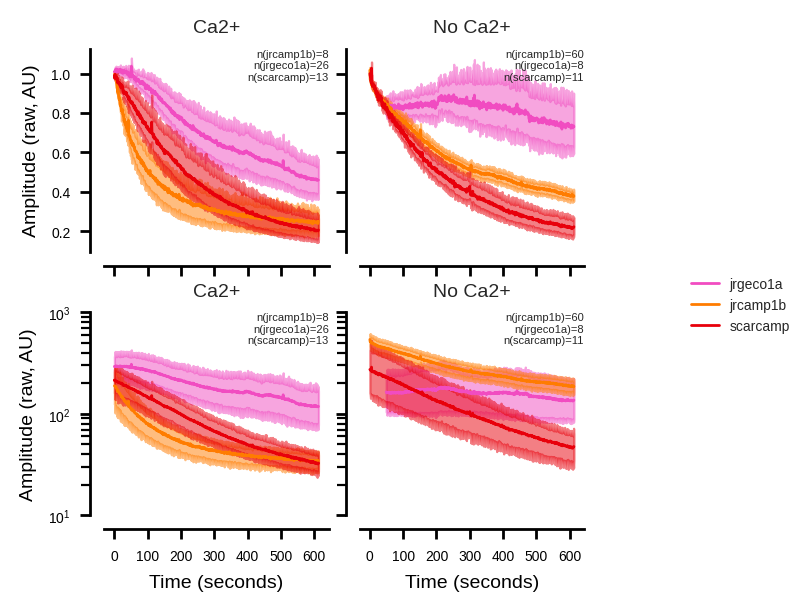

In [32]:
g = sns.relplot(
    data=plt_df.query("exp_type == 'bleaching' and ~exp_name.str.contains('egta1')"),
    x="tstamp_rel",
    y="value",
    kind="line",
    col="condition",
    col_order=["Ca2+", "No Ca2+"],
    row="variable",
    row_order=["norm_bleach_mean_intensity", "mean_intensity"],
    err_kws={"alpha": 0.5},
    errorbar=("ci", 95),
    hue="well_sanitized",
    height=1.5,
    facet_kws={"sharey": "row", "sharex": True},
    palette=pal,
)

g.set_titles(row_template="{row_name}", col_template="{col_name}")
for _ax in g.axes[1]:
    _ax.set_yscale("log")
    _ax.set_ylim([1e1, 1e3])
    # _ax.set_ylim([0.1, 2])
g.set(xlabel="Time")

def relabel_y(data, color=None):
    ax = plt.gca()
    use_label = data["variable"].iat[0]
    if use_label == "norm_amp":
        ax.set_ylabel("Amplitude (norm.)")
    else:
        ax.set_ylabel("Amplitude (raw, AU)")
    nrois = data.groupby("well_sanitized")["roi"].nunique()
    show_text = ""
    for _sensor, _nrois in nrois.items():
        show_text += f"n({_sensor})={_nrois}\n"
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    xrange = xlims[1] - xlims[0]
    yrange = ylims[1] - ylims[0]
    xpos = xlims[1]
    ypos = ylims[1]
    ax.text(xpos, ypos, show_text, ha="right", va="top", fontsize=4)


g.map_dataframe(relabel_y)
g.set_titles(template="{col_name}")
g.set(xlabel="Time (seconds)", xticks=np.arange(0, 601, 100))
g._legend.set_title("")
sns.despine(offset=5)
g.fig.savefig(os.path.join(fig_dir, "photobleaching_2p.pdf"), dpi=600, bbox_inches="tight")

In [33]:
# plot baseline brightness...

In [34]:
baseline_df = (
    plt_df.query("variable == 'mean_intensity'")
    .groupby(["well_sanitized", "condition", "roi"])["value"]
    .apply(lambda x: x.dropna().iloc[:5].mean())
    .reset_index()
)

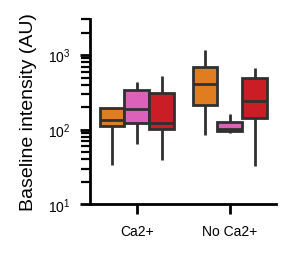

In [35]:
fig, ax = plt.subplots(1, figsize=(1.2, 1.2))
sns.boxplot(
    baseline_df,
    x="condition",
    # alpha=.35,
    order=["Ca2+", "No Ca2+"],
    y="value",
    hue="well_sanitized",
    palette=pal,
    legend=False,
    showfliers=False,
    showcaps=False,
    # dodge=True,
)
ax.set_yscale("log")
ax.set_ylim(1e1, 3e3)
ax.set_ylabel("Baseline intensity (AU)")
ax.set_xlabel("")
sns.despine()
fig.savefig(os.path.join(fig_dir, "baseline_brightness_2p.pdf"), dpi=600, bbox_inches="tight")

In [36]:
# compute bleaching rate, just take average dF/dt

In [40]:
import statsmodels.api as sm

In [41]:
def loess_slope(df, t="tstamp_rel", f="value", frac=0.1):
    F = df[f].to_numpy()
    t = df[t].to_numpy()

    idx = np.argsort(t)
    # t = t[idx]
    # F = F[idx]

    uniq_idx = np.unique(t, return_index=True)[1]
    t = t[uniq_idx]
    F = F[uniq_idx]

    # make sure everything is sorted

    if np.isnan(F).all():
        return None
    
    # remove nans
    nans1 = np.isnan(F)
    nans2 = np.isnan(t)
    allnans = nans1 | nans2

    F = F[~allnans]
    t = t[~allnans]
    F_norm = F / F[0]
    loess = sm.nonparametric.lowess(F_norm, t, frac=frac, return_sorted=True)
    t_smooth, F_smooth = loess[:,0], loess[:,1]
    dF_dt = np.gradient(F_smooth, t_smooth)
    avg_slope = np.nanmean(dF_dt)
    return avg_slope

use_slope = plt_df.query("variable == 'mean_intensity'").groupby(["well_sanitized", "condition", "roi"]).apply(loess_slope)

/tmp/ipykernel_3478224/2786720554.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  use_slope = plt_df.query("variable == 'mean_intensity'").groupby(["well_sanitized", "condition", "roi"]).apply(loess_slope)


In [42]:
photobleaching_df = ((use_slope * 60).dropna())
photobleaching_df.name = "bleach_rate_permin"
photobleaching_df = photobleaching_df.reset_index()

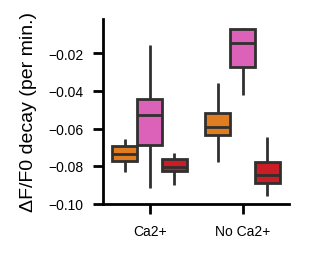

In [43]:
fig, ax = plt.subplots(1, figsize=(1.2, 1.2))
sns.boxplot(
    photobleaching_df,
    # alpha=0.35,
    x="condition",
    order=["Ca2+", "No Ca2+"],
    y="bleach_rate_permin",
    hue="well_sanitized",
    palette=pal,
    legend=False,
    showcaps=False,
    showfliers=False,
    # dodge=True,
)
ax.set_ylabel("ΔF/F0 decay (per min.)")
# ax.set_ylim(-.15, 0.0)
ax.set_xlabel("")
sns.despine()
fig.savefig(os.path.join(fig_dir, "photobleaching_rate_2p.pdf"), dpi=600, bbox_inches="tight")